In [112]:
from opsml.registry import DataCard, ModelCard, CardRegistry, LocalSQLConnection
from opsml.connector import SnowflakeQueryRunner

In [113]:
local_conn = LocalSQLConnection()
data_registry = CardRegistry(registry_name="data", connection_client=local_conn)

In [115]:
#data_registry.list_cards()

In [6]:
query_runner = SnowflakeQueryRunner(on_vpn=True) 
dataframe = query_runner.query_to_dataframe(sql_file="data.sql") 

In [116]:
dataframe.head()

,TIME_BUNDLE_ID,LOCAL_CREATED_DATE,LOCAL_CREATED_AT,METRO_ID,BUNDLE_TYPE,NBR_ADDRESSES,NBR_ORDERS,DROP_OFF_TIME,EVAL_FLG,EVAL_OUTLIER,NBR_RX,NBR_APT,DATE_DIFF,TRAIN_OUTLIER,SIN_DAY_WK,COS_DAY_WK,SIN_DAY_YR,COS_DAY_YR,SIN_MTH,COS_MTH,SIN_WK_YR,COS_WK_YR,NG_ORDER_ID,METRO_X,METRO_Y,METRO_Z,APT_FLG
0,4cc9dfdc-3f45-4059-a32c-f523c2e6ed6f,2023-01-22,2023-01-22 15:29:30.540773,279,TARP,1,1,5.765323,1,0,0,1,3,0,0.000000,1.000000,0.369725,0.929141,0.499998,0.866026,0.354603,0.935017,E_173223046,-2476.129544,-4684.469262,3537.537451,1
1,45906cef-be11-4e99-8a53-0bf02cddf9ad,2023-01-21,2023-01-21 16:51:33.521159,8,TARP,3,3,4.324033,1,0,3,3,3,0,-0.781831,0.623491,0.353675,0.935368,0.499998,0.866026,0.354603,0.935017,None,971.121016,-5637.844514,2803.796393,1
2,f26345af-3be2-407a-83b7-0eabbc4e71c4,2023-01-20,2023-01-20 09:45:52.491128,8,TARP,6,6,13.934235,1,0,0,6,3,0,-0.974928,-0.222519,0.337526,0.941316,0.499998,0.866026,0.354603,0.935017,None,971.121016,-5637.844514,2803.796393,1
3,81f49d88-2ad0-424c-b583-80147e3984b9,2023-01-17,2023-01-17 14:38:51.334024,15,TARP,2,2,12.475627,1,0,0,2,3,0,0.974928,-0.222519,0.288480,0.957486,0.499998,0.866026,0.354603,0.935017,None,801.337721,-5442.312393,3213.834886,1
4,b46a865a-7b1f-46f7-bdbb-6c54f77d1835,2023-01-18,2023-01-18 09:42:58.407282,79,TARP,3,3,13.551147,1,0,0,3,3,0,0.433886,-0.900968,0.304921,0.952378,0.499998,0.866026,0.354603,0.935017,None,176.377292,-4740.594241,4252.681306,1


In [117]:
features = [
    "NBR_ADDRESSES",
    "NBR_ORDERS",
    "NBR_RX",
    "NBR_APT",
    "METRO_X",
    "METRO_Y",
    "METRO_Z",
    "APT_FLG",
    "DROP_OFF_TIME",
    "EVAL_FLG",
]
DEPENDENT_VAR = "DROP_OFF_TIME"

# Define DataCard attributes (see examples dir for more detailed information)
DATA_NAME = "tarp_drop_off"
TEAM = "SPMS"
USER_EMAIL = "steven.forrester@shipt.com"
DATA_SPLITS = [
    {"label": "train", "column": "EVAL_FLG", "column_value": 0},
    {"label": "test", "column": "EVAL_FLG", "column_value": 1},
]

data_card = DataCard(
    data=dataframe[features],
    name=DATA_NAME,
    team=TEAM,
    user_email=USER_EMAIL,
    data_splits=DATA_SPLITS,
    dependent_vars=[DEPENDENT_VAR],

)

data_registry.register_card(card=data_card)

{"message": "DATA_REGISTRY: tarp_drop_off registered as version 9", "timestamp": "2023-02-09T17:22:07.459172Z", "app_env": "development", "level": "INFO"}


In [118]:
from lightgbm import LGBMRegressor

model_registry = CardRegistry(registry_name="model", connection_client=local_conn) #load the model registry

data_splits = data_card.split_data() # get the data splits defined by split logic (data_card.data_splits)

# Prepare train data
data_splits.train.pop("EVAL_FLG") # pop off eval flg
y_train = data_splits.train.pop("DROP_OFF_TIME") # get train target

# Prepare test data
data_splits.test.pop("EVAL_FLG") # pop off eval flg
y_test = data_splits.test.pop("DROP_OFF_TIME") # get test target

# fit model
lgb_model = LGBMRegressor()
lgb_model.fit(data_splits.train, y_train)

model_card = ModelCard(
    trained_model=lgb_model,
    sample_input_data=data_splits.train[:1],
    name="tarp_lgb",
    team="SPMS",
    user_email="steven.forrester@shipt.com",
    data_card_uid=data_card.uid
)

model_registry.register_card(card=model_card)

{"level": "INFO", "message": "Registering lightgbm onnx converter", "timestamp": "2023-02-09T17:23:23.983750Z", "app_env": "development", "host": null, "pid": 807773}
{"level": "INFO", "message": "Validating converted onnx model", "timestamp": "2023-02-09T17:23:24.325509Z", "app_env": "development", "host": null, "pid": 807773}
{"level": "INFO", "message": "Onnx model validated", "timestamp": "2023-02-09T17:23:24.351396Z", "app_env": "development", "host": null, "pid": 807773}
{"message": "MODEL_REGISTRY: tarp_lgb registered as version 8", "timestamp": "2023-02-09T17:23:24.382439Z", "app_env": "development", "level": "INFO"}


In [119]:
onnx_model = model_card.onnx_model()

In [120]:
onnx_model.input_sig.schema()

{'title': 'Features',
 'type': 'object',
 'properties': {'NBR_ADDRESSES': {'title': 'Nbr Addresses', 'type': 'integer'},
  'NBR_ORDERS': {'title': 'Nbr Orders', 'type': 'integer'},
  'NBR_RX': {'title': 'Nbr Rx', 'type': 'integer'},
  'NBR_APT': {'title': 'Nbr Apt', 'type': 'integer'},
  'METRO_X': {'title': 'Metro X', 'type': 'number'},
  'METRO_Y': {'title': 'Metro Y', 'type': 'number'},
  'METRO_Z': {'title': 'Metro Z', 'type': 'number'},
  'APT_FLG': {'title': 'Apt Flg', 'type': 'integer'}},
 'required': ['NBR_ADDRESSES',
  'NBR_ORDERS',
  'NBR_RX',
  'NBR_APT',
  'METRO_X',
  'METRO_Y',
  'METRO_Z',
  'APT_FLG']}

In [103]:
onnx_model.output_sig.schema()

{'title': 'Features',
 'type': 'object',
 'properties': {'variable': {'title': 'Variable', 'type': 'number'}},
 'required': ['variable']}

### Pipeline Viz

In [121]:
from opsml.registry import PipelineLoader
loader = PipelineLoader(pipeline_card_uid="afb7426bc42d4b4fb1ae14b44cee63f0", connection_type="local")

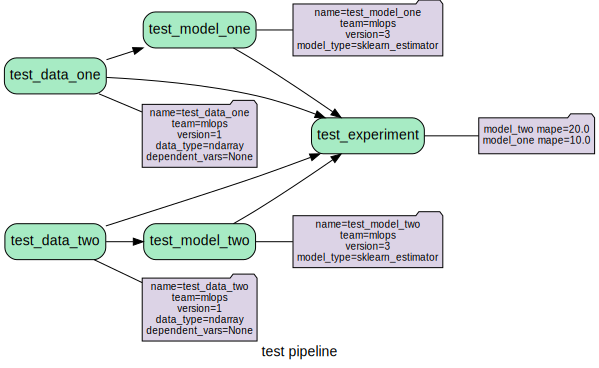

In [122]:
loader.visualize()

In [123]:
card_deck = loader.load_cards()

In [125]:
card_deck['test_experiment']

ExperimentCard(name='test_experiment', team='mlops', user_email='mlops.com', version=7, uid='33f814bdb8e04144b9754b2c3d0cbb91', data_card_uids=['4e6bb271c33f4e7594fb269767ead314', '04bca458445c4ee1ab84742a2bd54e8e'], model_card_uids=['adb54432b2a04048aa8beac28e75d855', 'd3a1f8d692ab440e8a11c4f4cd157af8'], pipeline_card_uid=None, metrics={'model_two mape': 20.0, 'model_one mape': 10.0}, artifacts={}, artifact_uris={}, storage_client=<opsml.registry.cards.storage_system.LocalStorageClient object at 0x7fce586f87c0>)

In [39]:
onnx_model = card_deck["test_model_two"].onnx_model()
onnx_model.input_sig.schema()

{'title': 'Features',
 'type': 'object',
 'properties': {'inputs': {'title': 'Inputs',
   'type': 'array',
   'items': {'type': 'number'}}},
 'required': ['inputs']}